<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/Neural_tangent_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/bobby-he/Neural_Tangent_Kernel.git

fatal: destination path 'Neural_Tangent_Kernel' already exists and is not an empty directory.


In [4]:
!ls

Neural_Tangent_Kernel  sample_data


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import seaborn as sns
sns.set()

In [0]:

torch.cuda.current_device()
use_cuda = True

# Reproducing the experiments in the neural tangent kernel paper.



## 6.2


### Define the network



In [0]:
class LinearNeuralTangentKernel(nn.Linear): 
    
    def __init__(self, in_features, out_features, bias=True, beta=0.1):
      self.beta = beta
      super(LinearNeuralTangentKernel, self).__init__(in_features, out_features)
      self.reset_parameters()
      
    def reset_parameters(self):
        torch.nn.init.normal_(self.weight, mean=0, std=1)
        if self.bias is not None:
          torch.nn.init.normal_(self.bias, mean=0, std=1)

    def forward(self, input):
        return F.linear(input, self.weight/np.sqrt(self.in_features), self.beta * self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, beta={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.beta
        )


In [0]:
class FourLayersNet(nn.Module):

  def __init__(self, n, beta=0.1):
      super(FourLayersNet, self).__init__()
      self.fc1 = LinearNeuralTangentKernel(2, n, beta=beta)
      self.fc2 = LinearNeuralTangentKernel(n, n, beta=beta)
      self.fc3 = LinearNeuralTangentKernel(n, n, beta=beta)
      self.fc4 = LinearNeuralTangentKernel(n, 1, beta=beta)

  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = self.fc4(x)
      return x

### Define the input data

In [0]:
gamma_data = torch.tensor(np.array([-2.2, -1, 1, 2.2]))

In [0]:
target_data = torch.tensor(np.array([-0.4, -0.2, 0.3, 0.3])).float()

In [0]:
def circle_transform(angle_vec):
  cos_tensor = torch.cos(angle_vec)
  sin_tensor = torch.sin(angle_vec)
  return torch.stack((cos_tensor, sin_tensor), -1).float()

In [0]:
input_data = circle_transform(gamma_data)

In [0]:
input_data

tensor([[-0.5885, -0.8085],
        [ 0.5403, -0.8415],
        [ 0.5403,  0.8415],
        [-0.5885,  0.8085]])

### Training example


In [0]:
net = FourLayersNet(10)


In [0]:
if use_cuda and torch.cuda.is_available():
  net.cuda()
  input_data = input_data.cuda()
  target_data = target_data.cuda()

In [0]:
def train_net(net, n_epochs, input_data, target):
  criterion = nn.MSELoss(reduction='mean')
  optimizer = optim.SGD(net.parameters(), lr=1)
  
  for epoch in range(n_epochs):  # loop over the dataset multiple times
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(input_data)
      
      #print(loss, sum(outputs))
      #print(net.fc4.bias[0])
      loss = criterion(outputs.view(-1), target)
      loss.backward()
      #print(loss)
      optimizer.step()

In [0]:
%%time

train_net(net, 1000, input_data, target_data)
#print(criterion(net(input_data.view(-1), target_data)))
#print(net(input_data))

Finished Training
CPU times: user 2.22 s, sys: 356 ms, total: 2.58 s
Wall time: 2.64 s


In [0]:
net(input_data)

tensor([[-0.4000],
        [-0.2000],
        [ 0.3000],
        [ 0.3000]], device='cuda:0', grad_fn=<AddmmBackward>)

### Plot basic example

In [0]:
gamma_vec = torch.tensor(np.linspace(-np.pi, np.pi, 100))
circle_points = circle_transform(gamma_vec).cuda()

In [0]:
output_vec = net(circle_points)
if use_cuda and torch.cuda.is_available():
  output_vec = output_vec.cpu()

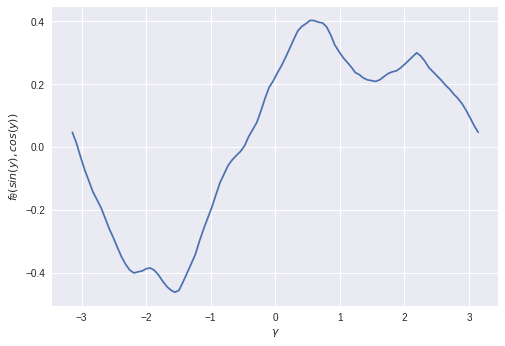

In [0]:
plt.plot(gamma_vec.numpy(), output_vec.detach().numpy())
plt.xlabel('$\gamma$')
plt.ylabel('$f_{ \\theta}(sin(y),cos(y))$')
plt.show()

In [0]:
target_data

tensor([-0.4000, -0.2000,  0.3000,  0.3000], device='cuda:0')

Finished Training
Finished Training
Completed initialisation 0
Finished Training
Finished Training
Completed initialisation 1
Finished Training
Finished Training
Completed initialisation 2
Finished Training
Finished Training
Completed initialisation 3
Finished Training
Finished Training
Completed initialisation 4
Finished Training
Finished Training
Completed initialisation 5
Finished Training
Finished Training
Completed initialisation 6
Finished Training
Finished Training
Completed initialisation 7
Finished Training
Finished Training
Completed initialisation 8
Finished Training
Finished Training
Completed initialisation 9


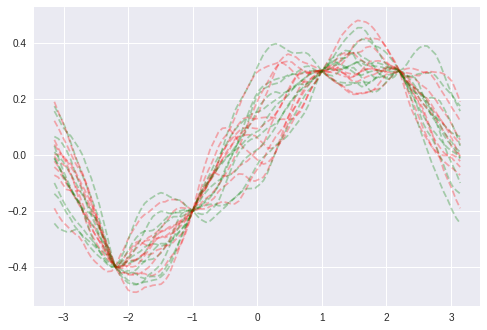

In [0]:
for i in range(10):
  # 1000 width first
  net = FourLayersNet(1000).cuda()  
  train_net(net, 1000, input_data, target_data)
  output_vec = net(circle_points)
  if use_cuda and torch.cuda.is_available():
    output_vec = output_vec.cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='red',
           linestyle='--', alpha = 0.3)
 
# 50 width
  net = FourLayersNet(1000).cuda()
  train_net(net, 1000, input_data, target_data)
  output_vec = net(circle_points)
  if use_cuda and torch.cuda.is_available():
    output_vec = output_vec.cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='green',
           linestyle='--', alpha = 0.3)
  
  print('Completed initialisation {}'.format(i))
   
   

In [0]:
net(input_data)

tensor([[0.1802],
        [0.2827],
        [0.1795],
        [0.2198]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
def train_net(net, n_epochs, input_data, target):
  criterion = nn.MSELoss(reduction='mean')
  optimizer = optim.SGD(net.parameters(), lr=1)
  
  for epoch in range(n_epochs):  # loop over the dataset multiple times

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(input_data)
      
      #print(loss, sum(outputs))
      #print(net.fc4.bias[0])
      loss = criterion(outputs.view(-1), target)
      loss.backward()
      #print(loss)
      optimizer.step()

<generator object Module.parameters at 0x7f61387db678>

### Getting the GP process plot is harder (I think) because of a lack of a standard kernel, here is an attempt but it is probably horrifically inefficient

In [0]:
n_pts=20 # number of points in plot
grad_mat = torch.zeros((n_pts,4))
net = FourLayersNet(100)
if use_cuda and torch.cuda.is_available():
  net.cuda()
  input_data = input_data.cuda()
  target_data = target_data.cuda()


In [0]:
gamma_test = torch.tensor(np.linspace(-np.pi,np.pi, n_pts))
initial_train = net(input_data) # this acts of f_0 on page 7 of NTK paper
initial_test = net(circle_transform(gamma_test).cuda())

In [0]:
train_net(net, 1000, input_data, target_data)

In [0]:
grad_list = []
for gamma in gamma_data:
  circle_pt = circle_transform(gamma)
  if use_cuda and torch.cuda.is_available():
    circle_pt = circle_pt.cuda()
  loss = net(circle_pt)
  grad_list.append(torch.autograd.grad(loss,net.parameters(), retain_graph = True))

In [0]:
# grad_mat is kappa on p7 of NTK paper
for i, gamma in enumerate(gamma_test):
  circle_pt = circle_transform(gamma)
  if use_cuda and torch.cuda.is_available():
    circle_pt = circle_pt.cuda()
  loss = net(circle_pt)
  grads = torch.autograd.grad(loss,net.parameters(), retain_graph = True) # extract NN gradients 
  for j in range(len(grad_list)):
    pt_grad = grad_list[j] # the gradients at the jth (out of 4) data point
    grad_mat[i, j] = sum([torch.sum(torch.mul(grads[u], pt_grad[u])) for u in range(len(grads))])

In [0]:
# let's create Ktilde matrix from p7 of NTK paper
tilde_mat = torch.zeros((4,4))
for i in range(4):
  grad_i = grad_list[i]
  for j in range(i+1):
    grad_j = grad_list[j]
    tilde_mat[i, j] = sum([torch.sum(torch.mul(grad_i[u], grad_j[u])) for u in range(len(grads))])
    tilde_mat[j, i] = tilde_mat[i, j]
    
tilde_inv = torch.inverse(tilde_mat)

In [0]:
temp_mat = torch.mm(grad_mat, tilde_inv)

In [0]:
temp_mat.device

device(type='cpu')

In [0]:
target_data = target_data.cpu()

In [0]:
mean_vec = torch.mm(temp_mat, target_data.unsqueeze(1)) #+ initial_test.cpu() - torch.mm(temp_mat, initial_train.cpu())

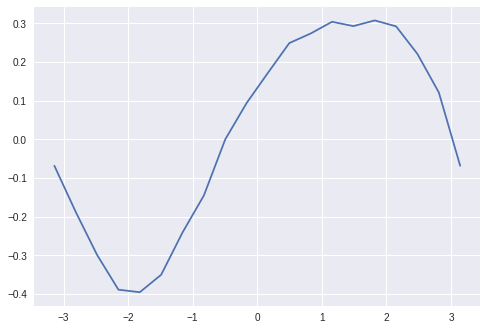

In [0]:
plt.plot(gamma_test.numpy(), mean_vec.detach().numpy())

### It remains to estimate sigma matrix

In [0]:
new_model = nn.Sequential(*(list(net.children())[:-1]))

In [0]:
new_model = nn.Sequential(new_model, nn.ReLU())

In [0]:
torch.mean(new_model(input_data), dim=1, keepdim=True)

tensor([[0.3217],
        [0.2725],
        [0.2903],
        [0.2419]], device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
sigma_testvtest = torch.mean(new_model(circle_transform(gamma_test).cuda())**2, dim = 1, keepdim=True) + torch.tensor(0.01) # n_pts x 1 dim vector 


In [0]:
sigma_testvtest.shape

torch.Size([20, 1])

In [0]:
sigma_testvtrain = torch.mm(new_model(circle_transform(gamma_test).cuda()),torch.t(new_model(input_data)))/100 + torch.tensor(0.01) # n_pts x 4 dim matrix
sigma_testvtrain.shape

torch.Size([20, 4])

In [0]:
sigma_trainvtrain = torch.mm(new_model(input_data),torch.t(new_model(input_data)))/100 + torch.tensor(0.01) # 4 x 4 dim matrix

In [0]:
variance_vec = sigma_testvtest.view(-1) -2 * torch.diag(torch.mm(sigma_testvtrain,torch.t(temp_mat.cuda()))) + torch.diag(torch.mm(temp_mat.cuda(), torch.mm(sigma_trainvtrain, torch.t(temp_mat.cuda()))))

In [0]:
torch.diag(torch.mm(sigma_testvtrain,torch.t(temp_mat.cuda()))).shape

torch.Size([20])

In [0]:
torch.diag(torch.mm(temp_mat.cuda(), torch.mm(sigma_trainvtrain, torch.t(temp_mat.cuda())))).view(-1).shape

torch.Size([20])

In [0]:
variance_vec = variance_vec.cpu()

In [0]:
variance_vec.requires_grad

True

In [0]:
variance_vec.shape

torch.Size([20])

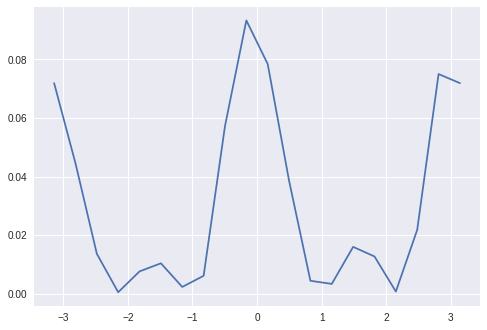

In [0]:
plt.plot(gamma_test.numpy(), variance_vec.detach().numpy())

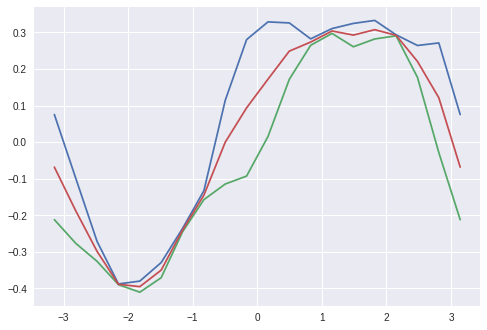

In [0]:
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+2*variance_vec.detach().numpy())
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()-2*variance_vec.detach().numpy())
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+0*variance_vec.detach().numpy())